In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import yfinance as yf
from datetime import datetime
import pandas as pd
import psycopg2
import configparser
import datetime
import nbimporter
from Connection_to_pgAdmin4 import *
from SQL import *

In [2]:

# Function to execute SQL queries
#SQL REFERENCE A


def execute_sql_query(query, params=None):
    
    # Establish a connection to the database
    connection = connect_to_database()

    try:
        if connection:
            cursor = connection.cursor()
            
            # Execute the SQL query
            if params:
                cursor.execute(query, params)
            else:
                cursor.execute(query)

            # If it's a SELECT query, fetch the results
            if query.strip().lower().startswith("select"):
                results = cursor.fetchall()
                cursor.close()
                return results

            # For other types of queries, commit the changes
            else:
                connection.commit()
               # print("Query executed successfully.")

    except (Exception, psycopg2.Error) as error:
        print(f"Error: {error}")
        if connection:
            connection.rollback()

    finally:
        if connection:
            connection.close()


In [3]:
# Function to fetch financial information for the last 3 months from the database.
def fetch_financial_info():
    # SQL query to select data from the last 3 months, ordered by Date and Symbol.
    query = """
    SELECT Date, Symbol, Open, High, Low, Close, Volume
    FROM dimension.d_financial_info
    WHERE Date > CURRENT_DATE - INTERVAL '3 months'
    ORDER BY Date DESC, Symbol
    """
    
    # Execute the SQL query and store the result.
    financial_data = execute_sql_query(query)
    
    # Check if the query returned any data.
    if financial_data:
        # Define column names for the pandas DataFrame.
        columns = ['Date', 'Symbol', 'Open', 'High', 'Low', 'Close', 'Volume']
        
        # Create a pandas DataFrame with the financial data.
        df = pd.DataFrame(financial_data, columns=columns)
        
        # Print the count of NaN values in each column.
        print(df.isnull().sum())  
        
        # Fill NaN values with zero. Alternative handling could be to use the mean.
        df.fillna(0, inplace=True)
        
        # Return the DataFrame with financial data.
        return df
    else:
        # Return None if no data was found.
        return None



In [5]:
# Function to preprocess financial data along with symbols and dates for LSTM model input.
# Window Size 30
def preprocess_data_with_symbols(df, seq_length=30):
    # Initialise a MinMaxScaler to scale features between 0 and 1.
    scaler = MinMaxScaler(feature_range=(0, 1))
    
    # Get unique symbols from the DataFrame.
    symbols = df['Symbol'].unique()
    
    # Lists to store processed sequences, their corresponding symbols, and dates.
    processed_data = []
    sequence_symbols = []  # Keeps track of symbols for each processed sequence.
    sequence_dates = []  # Keeps track of the date for the last data point in each sequence.
    
    # Iterate over each symbol to process data symbol-wise.
    for symbol in symbols:
        # Create a copy of the DataFrame filtered by current symbol and sort it by date.
        data_symbol = df[df['Symbol'] == symbol].copy()
        data_symbol.sort_values(by='Date', inplace=True)
        
        # Scale the features (Open, High, Low, Close, Volume) for the current symbol.
        scaled_features = scaler.fit_transform(data_symbol[['Open', 'High', 'Low', 'Close', 'Volume']])
        
        # Generate sequences of length 'seq_length' for LSTM input.
        for i in range(len(scaled_features) - seq_length):
            # Each sequence contains 'seq_length' consecutive days of data.
            seq = scaled_features[i:i + seq_length + 1]
            processed_data.append(seq)
            sequence_symbols.append(symbol)  # Associate the current symbol with the sequence.
            # Associate the date of the last data point in the sequence.
            sequence_dates.append(data_symbol.iloc[i + seq_length - 1]['Date'])
            
    # Return the processed sequences, scaler, symbols, and dates as a tuple.
    return np.array(processed_data), scaler, sequence_symbols, sequence_dates



In [6]:
# Defines a function to build an LSTM model with a specified input shape.

def build_model(input_shape):
    # Initialises a Sequential model.
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),  # First LSTM layer with 50 units, returns sequences for further layers.
        LSTM(50),  # Second LSTM layer with 50 units.
        Dense(5)  # Dense layer with 5 units for output, matching the number of predicted features.
    ])
    
    # Compiles the model with the Adam optimizer and mean squared error loss function.
    model.compile(optimizer='adam', loss='mean_squared_error')
    # Returns the compiled model.
    return model


In [7]:
# Main function to execute the model pipeline.
def main():
    # Fetch financial information from the database for the last 3 months.
    df = fetch_financial_info()
    
    # Check if the DataFrame is not empty.
    if df is not None:
        # Preprocess the data to prepare sequences for LSTM model training.
        
        # This includes scaling of features and associating symbols and dates with each sequence.
        processed_data, scaler, sequence_symbols, sequence_dates = preprocess_data_with_symbols(df)
        
        # Shuffle the sequences to randomize the order before splitting into training and testing sets.
        # This step helps in generalizing the model by training on a random sample of sequences.
        indices = np.arange(processed_data.shape[0])
        np.random.shuffle(indices)
        processed_data = processed_data[indices]
        sequence_symbols = np.array(sequence_symbols)[indices]
        sequence_dates = np.array(sequence_dates)[indices]  # Matching dates are shuffled similarly to maintain alignment.
        
        # Split the data into training and testing sets, maintaining an 80-20 split.
        train_size = int(len(processed_data) * 0.8)
        X_train, y_train = processed_data[:train_size, :-1], processed_data[:train_size, -1][:, :5]
        X_test, y_test = processed_data[train_size:, :-1], processed_data[train_size:, -1][:, :5]
        # Extract symbols and dates for the test set to correlate predictions with specific symbols and dates.
        test_symbols = sequence_symbols[train_size:]
        test_dates = sequence_dates[train_size:]
        
        # Initialize and train the LSTM model on the training set.
        model = build_model((X_train.shape[1], X_train.shape[2]))
        history = model.fit(X_train, y_train, epochs=20, batch_size=30, validation_split=0.1, verbose=1)
        
        # Evaluate the model's performance on the test set.
        loss = model.evaluate(X_test, y_test, verbose=1)
        
        # Generate predictions for the test set using the trained model.
        predictions = model.predict(X_test)
        
        # Save model 
        model.save('PredictiveModel6_30days_sequense.h5')

        
        # Return a dictionary containing the test set, predictions, model information, and associated symbols and dates.
        # This comprehensive return structure allows for detailed analysis and further processing of the model's predictions.
        return {
            "X_test": X_test,  # Input features for the test set
            "y_test": y_test,  # True output values for the test set
            "predictions": predictions,  # Predicted output values by the model
            "scaler": scaler,  # Scaler object for inverse transformation of predictions
            "model": model,  # Trained LSTM model
            "history": history,  # Training history for analysis
            "loss": loss,  # Loss on the test set for evaluation
            "test_symbols": test_symbols,  # Symbols associated with the test set
            "test_dates": test_dates  # Dates associated with the test set predictions
        }
    else:
        # If no financial data is found, print a message and return None.
        print("No financial data found for the given period.")
        return None


In [8]:
results = main()

Date       0
Symbol     0
Open      36
High      36
Low       36
Close     36
Volume     0
dtype: int64
Epoch 1/20
3230/3230 [==============================] - 53s 16ms/step - loss: 0.0241 - val_loss: 0.0208
Epoch 2/20
3230/3230 [==============================] - 54s 17ms/step - loss: 0.0200 - val_loss: 0.0199
Epoch 3/20
3230/3230 [==============================] - 52s 16ms/step - loss: 0.0190 - val_loss: 0.0188
Epoch 4/20
3230/3230 [==============================] - 59s 18ms/step - loss: 0.0179 - val_loss: 0.0174
Epoch 5/20
3230/3230 [==============================] - 52s 16ms/step - loss: 0.0172 - val_loss: 0.0172
Epoch 6/20
3230/3230 [==============================] - 51s 16ms/step - loss: 0.0168 - val_loss: 0.0167
Epoch 7/20
3230/3230 [==============================] - 50s 16ms/step - loss: 0.0165 - val_loss: 0.0164
Epoch 8/20
3230/3230 [==============================] - 54s 17ms/step - loss: 0.0163 - val_loss: 0.0162
Epoch 9/20
3230/3230 [==============================] - 53s 16ms

/Users/shabanyounas/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [11]:
if results:
    # Inverse transform the predictions and true values to their original scale
    predictions_inverse = results['scaler'].inverse_transform(results['predictions'])
    
    y_test_inverse = results['scaler'].inverse_transform(results['y_test'])

    # Print the first few predictions vs. true values for comparison
    print("Predictions vs. True Values:")
    for i in range(10):  # Adjust the range as needed
        print(f"Prediction {i+1}: {predictions_inverse[i]}, True Value {i+1}: {y_test_inverse[i]}")

Predictions vs. True Values:
Prediction 1: [1.0901388 1.1051853 1.099836  1.0382605 2.0111296], True Value 1: [1.11 1.11 1.11 1.11 2.  ]
Prediction 2: [0.29248652 0.27722317 0.29436776 0.28988886 2.0701218 ], True Value 2: [0.29939394 0.30083969 0.28424242 0.29939394 2.03796269]
Prediction 3: [0.8503106 0.8469672 0.8443345 0.8606774 2.361395 ], True Value 3: [0.87255031 0.83988298 0.7928909  0.86601988 2.16058946]
Prediction 4: [1.0182178 1.1343833 0.7895787 1.0176924 2.2966661], True Value 4: [1.11      1.11      1.11      1.11      2.9226338]
Prediction 5: [1.0461088 1.0534239 1.0452908 1.0418941 2.0539587], True Value 5: [1.05930437 1.05930437 1.05930437 1.05930437 2.        ]
Prediction 6: [0.48435563 0.3750311  0.6358979  0.5082471  2.1308007 ], True Value 6: [0.48142857 0.36531915 0.55444444 0.4130303  2.22111003]
Prediction 7: [0.5456591 0.4898262 0.5662446 0.5860927 2.1981022], True Value 7: [0.46714286 0.37108374 0.66555556 0.68142857 2.12333742]
Prediction 8: [0.1550469  0.15

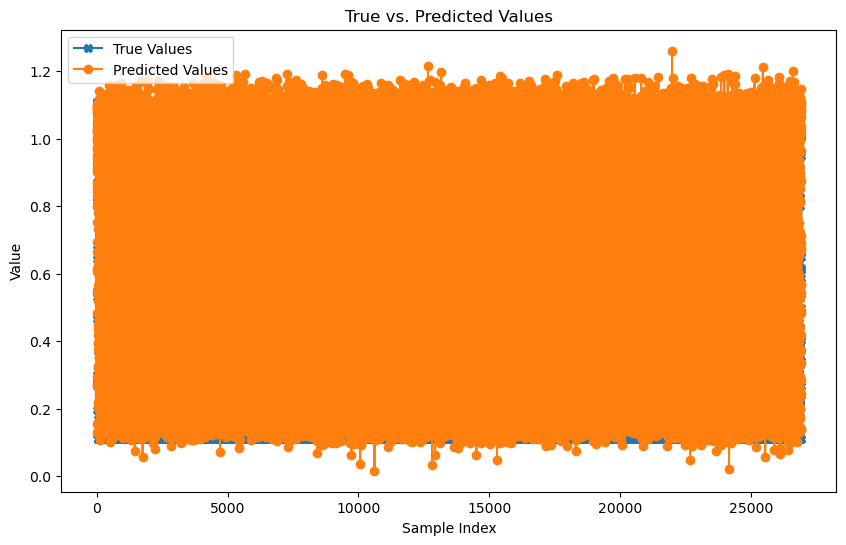

In [12]:
import matplotlib.pyplot as plt

# Check if the results from the model are available.
if results:
    # Initialise a new figure for plotting with dimensions 10x6 inches.
    plt.figure(figsize=(10, 6))
    
    # Plot the true values for the first feature across all samples in the test set,
    # marking each point with an 'X'.
    plt.plot(y_test_inverse[:, 0], label='True Values', marker='X')  # The first feature is selected with [:, 0].
    
    # Plot the predicted values for the same feature, using circles ('o') to mark each predicted point.
    plt.plot(predictions_inverse[:, 0], label='Predicted Values', marker='o')  # Likewise, focusing on the first feature.
    
    # Set the title of the plot to indicate it's comparing true values against predicted ones.
    plt.title('True vs. Predicted Values')
    
    # Label the x-axis as 'Sample Index' to indicate the position of each sample in the dataset.
    plt.xlabel('Sample Index')
    
    # Label the y-axis as 'Value' to denote the value of the feature being plotted.
    plt.ylabel('Value')
    
    # Add a legend to the plot to distinguish between true and predicted values visually.
    plt.legend()
    
    # Display the plot.
    plt.show()


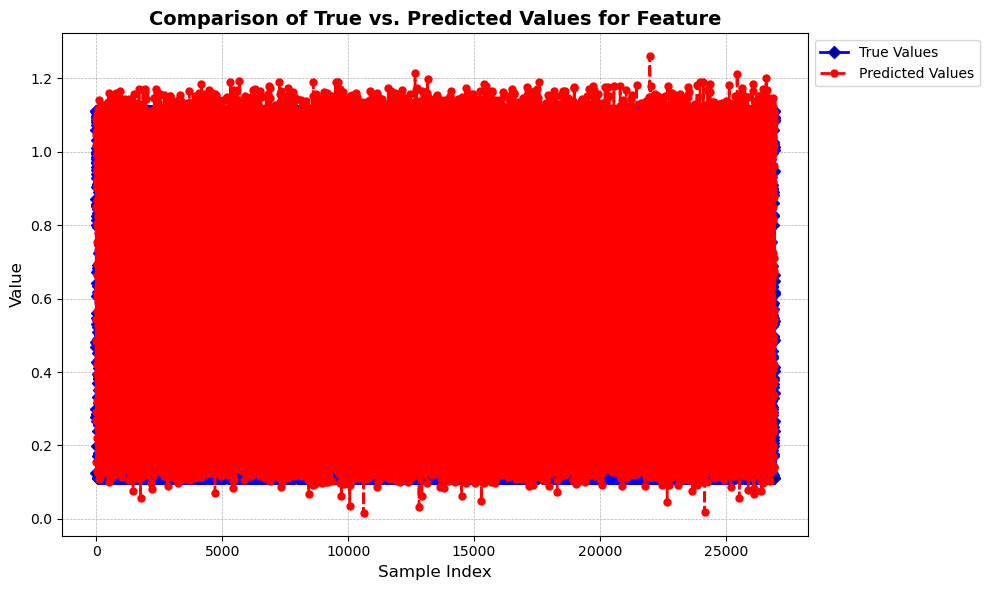

In [13]:
#Second Visualisation 

if results:
    # Initialise a figure for plotting with dimensions 10x6 inches for better visibility.
    plt.figure(figsize=(10, 6))
    
    # Plot the true values with a solid blue line and diamond markers.
    plt.plot(y_test_inverse[:, 0], 'b-',
             label='True Values', linewidth=2, marker='D', markersize=6, markerfacecolor='navy')
    
    # Plot the predicted values with a dashed orange line and circle markers.
    plt.plot(predictions_inverse[:, 0], 'r--',
             label='Predicted Values', linewidth=2, marker='o', markersize=5, markerfacecolor='red')
    
    # Set a more descriptive title to provide context.
    plt.title('Comparison of True vs. Predicted Values for Feature', fontsize=14, fontweight='bold')
    
    # Label axes with more detail.
    plt.xlabel('Sample Index', fontsize=12)
    plt.ylabel('Value', fontsize=12)
    
    # Add a grid to the background for better readability.
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    # Add a legend with an optimal position outside the plot area.
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    
    # Adjust layout to make room for the legend.
    plt.tight_layout()
    
    # Display the enhanced plot.
    plt.show()

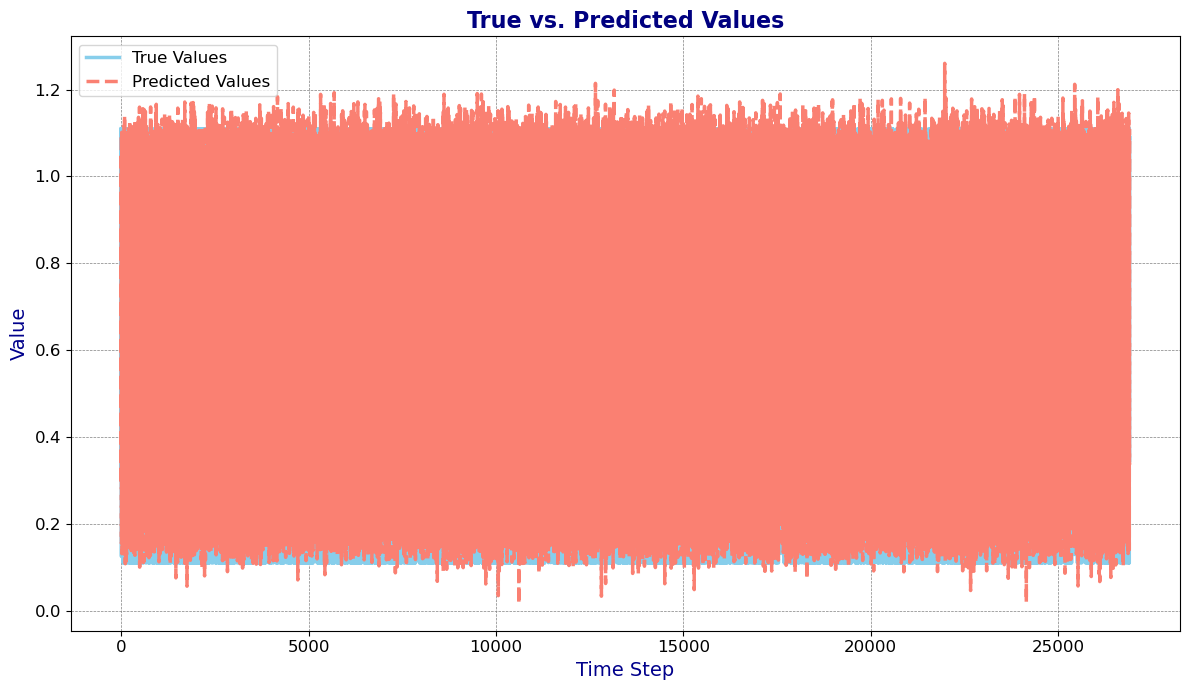

In [14]:
#Third Visualisation

if results:
    # Initialize the plot with a specific size for better visibility
    plt.figure(figsize=(12, 7))

    # Plot the true values using a solid line
    plt.plot(y_test_inverse[:, 0], label='True Values', color='skyblue', linewidth=2.5, linestyle='-')

    # Plot the predicted values using a different style
    plt.plot(predictions_inverse[:, 0], label='Predicted Values', color='salmon', linewidth=2.5, linestyle='--')

    # Adding some aesthetics to make the chart more readable and visually appealing
    plt.title('True vs. Predicted Values', fontsize=16, fontweight='bold', color='navy')
    plt.xlabel('Time Step', fontsize=14, color='darkblue')
    plt.ylabel('Value', fontsize=14, color='darkblue')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # Enable grid for better readability
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='grey')
    
    # Add a legend to help differentiate between true and predicted values
    plt.legend(loc='best', fontsize=12)

    # Ensure everything fits without clipping
    plt.tight_layout()

    # Display the plot
    plt.show()

In [15]:
if results:
    # Update the 'predictions' key in the results dictionary with model predictions on the test set.
    results['predictions'] = results['model'].predict(results['X_test'])
    
    # Apply inverse transformation back to their original scale.
    predictions_inverse = results['scaler'].inverse_transform(results['predictions'])
    y_test_inverse = results['scaler'].inverse_transform(results['y_test'])
    
    # Compile a DataFrame for a side-by-side comparison of true and predicted 'Open' values,
    # including the symbol associated with each prediction.
    comparison_df = pd.DataFrame({
        'Symbol': results['test_symbols'],  # Symbols associated with test data
        'True_Open': y_test_inverse[:, 0],  # True 'Open' values in original scale
        'Predicted_Open': predictions_inverse[:, 0],  # Predicted 'Open' values in original scale
        # Extend with more columns as necessary for additional comparison
    })
    
    # Display the first 100 rows of the comparison DataFrame for review.
    print(comparison_df.head(20))


842/842 [==============================] - 4s 5ms/step
    Symbol  True_Open  Predicted_Open
0    MRC.L   1.110000        1.090139
1   IWVG.L   0.299394        0.292487
2   DPLM.L   0.872550        0.850311
3   MSMN.L   1.110000        1.018218
4   CNAL.L   1.059304        1.046109
5    EOG.L   0.481429        0.484356
6    CTO.L   0.467143        0.545659
7   IPRP.L   0.124898        0.155047
8    TRT.L   0.276667        0.268997
9   VUKG.L   0.800476        0.693466
10  SAGG.L   0.904393        0.908965
11  JPHG.L   0.853428        0.869225
12  TIDE.L   0.643333        0.663914
13  SSIT.L   0.531520        0.800662
14  SDIG.L   1.106666        1.095723
15  HMJD.L   1.092203        1.101725
16   INF.L   1.080120        1.091871
17  AAIF.L   0.999294        0.992057
18   FRP.L   0.197302        0.131361
19  EMHF.L   0.814123        0.926069


In [16]:
def insert_predictions(insert_data):
    table_name = "dimension.predictive_Model6_results"
    # Define the SQL insert statement
    insert_query_template = f"""
    INSERT INTO {table_name} (
        Symbol, True_Open, True_High, True_Low, True_Close, True_Volume,
        Predicted_Open, Predicted_High, Predicted_Low, Predicted_Close, Predicted_Volume,
        DateTo)
    VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s);
    """
    
    for row in insert_data:
        # Prepare the values for insertion
        values = (
            row["Symbol"],
            row["True_Open"], row["True_High"], row["True_Low"], row["True_Close"], row["True_Volume"],
            row["Predicted_Open"], row["Predicted_High"], row["Predicted_Low"], row["Predicted_Close"], row["Predicted_Volume"],
            row["DateTo"]
        )
        
        # Use the execute_sql_query function to insert the data
        execute_sql_query(insert_query_template, values)


In [17]:
if results:
    predictions_inverse = results['scaler'].inverse_transform(results['predictions'])
    y_test_inverse = results['scaler'].inverse_transform(results['y_test'])
    test_symbols = results['test_symbols']
    test_dates = results['test_dates']  # This now holds the prediction dates

    insert_data = []
    for i in range(len(predictions_inverse)):
        # Format test_dates[i] as needed, e.g., to string if it's not already
        prediction_date_str = test_dates[i].strftime('%Y-%m-%d')
        row = {
            "Symbol": test_symbols[i],
            "True_Open": round(float(y_test_inverse[i, 0]), 2),
            "True_High": round(float(y_test_inverse[i, 1]), 2),
            "True_Low": round(float(y_test_inverse[i, 2]), 2),
            "True_Close": round(float(y_test_inverse[i, 3]), 2),
            "True_Volume": round(float(y_test_inverse[i, 4]), 2),
            "Predicted_Open": round(float(predictions_inverse[i, 0]), 2),
            "Predicted_High": round(float(predictions_inverse[i, 1]), 2),
            "Predicted_Low": round(float(predictions_inverse[i, 2]), 2),
            "Predicted_Close": round(float(predictions_inverse[i, 3]), 2),
            "Predicted_Volume": round(float(predictions_inverse[i, 4]), 2),
            "DateTo": prediction_date_str
        }
        insert_data.append(row)

    # Now call insert_predictions with the prepared insert_data
    insert_predictions(insert_data)

